In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "clean_data_MSK.csv"
data = pd.read_csv(PATH, sep=':')
data = data[(data['long'] < 37.9545100) & (data['long'] > 37.1813900) & (data['lat'] < 55.9825000) & (data['lat'] > 55.1339600)].copy()
data.head(2)

,lighting,lat,long,region,category,date,severity,dead,injured,n_participants,dr_exp,w_percent,Температура выше +30С,Пасмурно,Туман,Снегопад,Температура ниже -30С,Дождь,Ураганный ветер,Ясно,Метель,"Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств",Низкие сцепные качества покрытия,Сухое,Свежеуложенная поверхностная обработка,Отсутствие временных ТСОД в местах проведения работ,Иные недостатки,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Мокрое,Залитое (покрытое) водой,Неисправное освещение,Недостатки зимнего содержания,Отсутствие освещения,Отсутствие дорожных знаков в необходимых местах,Несоответствие дорожных ограждений предъявляемым требованиям,Отсутствие направляющих устройств и световозвращающих элементов на них,Отсутствие дорожных ограждений в необходимых местах,Обработанное противогололедными материалами,Недостаточное освещение,Нарушения в размещении наружной рекламы,...,Гололедица,Несоответствие железнодорожного переезда предъявляемым требованиям,Грузовые автомобили,Легковые автомобили (представительские),Специализированные машины,Прочие ТС,Легковые автомобили,Общественный транспорт,Мототранспортные средства,Водитель Эксплуатация,Водитель Нарушения при движении,Водитель Пешеходы,Водитель Нарушение правил эксплуатации мототранспорта,Водитель Нарушение правил безопасности при управлении,Водитель Нарушение правил перевозки людей/грузов,Водитель Другое,Водитель Нарушение правил подачи/приема сигналов,Водитель Ранения,Водитель Скончался после госпитализации,Водитель Легкие травмы,Водитель Не пострадал,Водитель Скончался до госпитализации,Регулируемые перекрестки,Регулируемые пешеходные переходы,Эстакада/Мост/Тоннель,Места скопления автотранспорта,Нерегулируемые пешеходные переходы,Места скопления людей,Нерегулируемые перекрестки,Иные объекты,Эксплуатация,Нарушение правил подачи/приема сигналов,Другое,Нарушения при движении,Пешеходы,Скончался до госпитализации,Не пострадал,Легкие травмы,Ранения,Скончался после госпитализации
0,Светлое время суток,55.616777,37.706516,Орехово-Борисово Северное,Наезд на пешехода,2020-03-24 13:06:00,Легкий,0,1,2,[28],0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,Светлое время суток,55.841157,37.489332,Головинский,Столкновение,2018-09-15 11:00:00,Легкий,0,1,2,"[20, 6]",0.5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Embeddings constraction based on ts and clustering:

In [164]:
time2risk = [0.1168, 0.1174, 0.1564, 0.1296, 0.1153, 0.1293, 0.0963, 0.0562,
       0.029 , 0.0364, 0.0353, 0.0406, 0.0407, 0.0366, 0.0343, 0.0351,
       0.0352, 0.0393, 0.0447, 0.0515, 0.0494, 0.0573, 0.0778, 0.0762]

In [166]:
day_time = data['date'].apply(lambda x: int(x.split()[1][:2])).copy()
death_risk = [time2risk[time] for time in day_time]
inAccident_risk = [1 if 2<=time<=6 else ( 3 if 13<=time<=21 else 2) for time in day_time]

In [167]:
from sklearn.cluster import DBSCAN

def select_problematic_clusters(coordinates, distance: float, min_samples: int) -> DBSCAN:
    """
    ==========
    Parameters:
        coordinates: pd.Dataframe or np.array containing latitude and longitude
        distance: float, neighbourhood distance for DBSCAN;

        intuitively, this parameter helps us to define the most problematic regions with accidents, according to which
        neighbourhood distance between the accidents is at most 'distance' km

        min_samples: int, number of samples for accident to be considered as core point by DBSCAN
        
        intuitively, min_samples helps us regulate the density of problematic regions

    ==========
    Return:
        DBSCAN – fitted DBSCAN model
    """
    model = DBSCAN(eps=distance/6371., min_samples=min_samples, metric='haversine')
    model.fit(np.radians(coordinates))
    return model
    
model = select_problematic_clusters(data[['lat', 'long']].values, 0.1, 15)
risky_areas = np.where(model.labels_ == -1, 0, 1)

In [168]:
new_embeddings = data[['date']].copy()

new_embeddings["death_risk"] = death_risk
new_embeddings["inAccident_risk"] = inAccident_risk
new_embeddings["risky_areas"] = risky_areas
del new_embeddings["date"]

new_embeddings.head(10)

,death_risk,inAccident_risk,risky_areas
0,0.0366,3,0
1,0.0406,2,0
2,0.0573,3,0
3,0.0447,3,0
4,0.0406,2,0
5,0.0573,3,0
6,0.0407,2,0
7,0.1296,1,0
8,0.0515,3,0
9,0.0351,3,1


### Binary-encoded values and their preprocessing 

In [216]:
data.columns[:12]

Index(['lighting', 'lat', 'long', 'region', 'category', 'date', 'severity',
       'dead', 'injured', 'n_participants', 'dr_exp', 'w_percent'],
      dtype='object')

In [224]:
cols = ['lighting', 'lat', 'long', 'region', 'category', 'date', 'severity',
       'dead', 'injured', 'n_participants', 'dr_exp', 'w_percent',
       'Температура выше +30С', 'Пасмурно', 'Туман', 'Снегопад',
       'Температура ниже -30С', 'Дождь', 'Ураганный ветер', 'Ясно', 'Метель',
       'Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств',
       'Низкие сцепные качества покрытия', 'Сухое',
       'Свежеуложенная поверхностная обработка',
       'Отсутствие временных ТСОД в местах проведения работ',
       'Иные недостатки',
       'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта',
       'Мокрое', 'Залитое (покрытое) водой', 'Неисправное освещение',
       'Недостатки зимнего содержания', 'Отсутствие освещения',
       'Отсутствие дорожных знаков в необходимых местах',
       'Несоответствие дорожных ограждений предъявляемым требованиям',
       'Отсутствие направляющих устройств и световозвращающих элементов на них',
       'Отсутствие дорожных ограждений в необходимых местах',
       'Обработанное противогололедными материалами',
       'Недостаточное освещение', 'Нарушения в размещении наружной рекламы',
       'Со снежным накатом', 'Загрязненное', 'Не установлено',
       'Неправильное применение, плохая видимость дорожных знаков',
       'Неудовлетворительное состояние обочин', 'Заснеженное',
       'Ограничение видимости', 'Неисправность светофора',
       'Плохая видимость световозвращателей, размещенных на дорожных ограждениях',
       'Отсутствие, плохая различимость горизонтальной разметки проезжей части',
       'Отсутствие пешеходных ограждений в необходимых местах',
       'Плохая видимость светофора',
       'Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям',
       'Пыльное', 'Неудовлетворительное состояние разделительной полосы',
       'Неровное покрытие', 'Дефекты покрытия',
       'Отсутствие, плохая различимость вертикальной разметки',
       'Отсутствие тротуаров (пешеходных дорожек)', 'Гололедица',
       'Несоответствие железнодорожного переезда предъявляемым требованиям',
       'Грузовые автомобили', 'Легковые автомобили (представительские)',
       'Специализированные машины', 'Прочие ТС', 'Легковые автомобили',
       'Общественный транспорт', 'Мототранспортные средства',
       'Водитель Эксплуатация', 'Водитель Нарушения при движении',
       'Водитель Пешеходы',
       'Водитель Нарушение правил эксплуатации мототранспорта',
       'Водитель Нарушение правил безопасности при управлении',
       'Водитель Нарушение правил перевозки людей/грузов', 'Водитель Другое',
       'Водитель Нарушение правил подачи/приема сигналов',
       'Регулируемые перекрестки', 'Регулируемые пешеходные переходы',
       'Эстакада/Мост/Тоннель', 'Места скопления автотранспорта',
       'Нерегулируемые пешеходные переходы', 'Места скопления людей',
       'Нерегулируемые перекрестки', 'Иные объекты', 'Эксплуатация',
       'Нарушение правил подачи/приема сигналов', 'Другое',
       'Нарушения при движении', 'Пешеходы']

sample = data[cols].iloc[:, 12:]

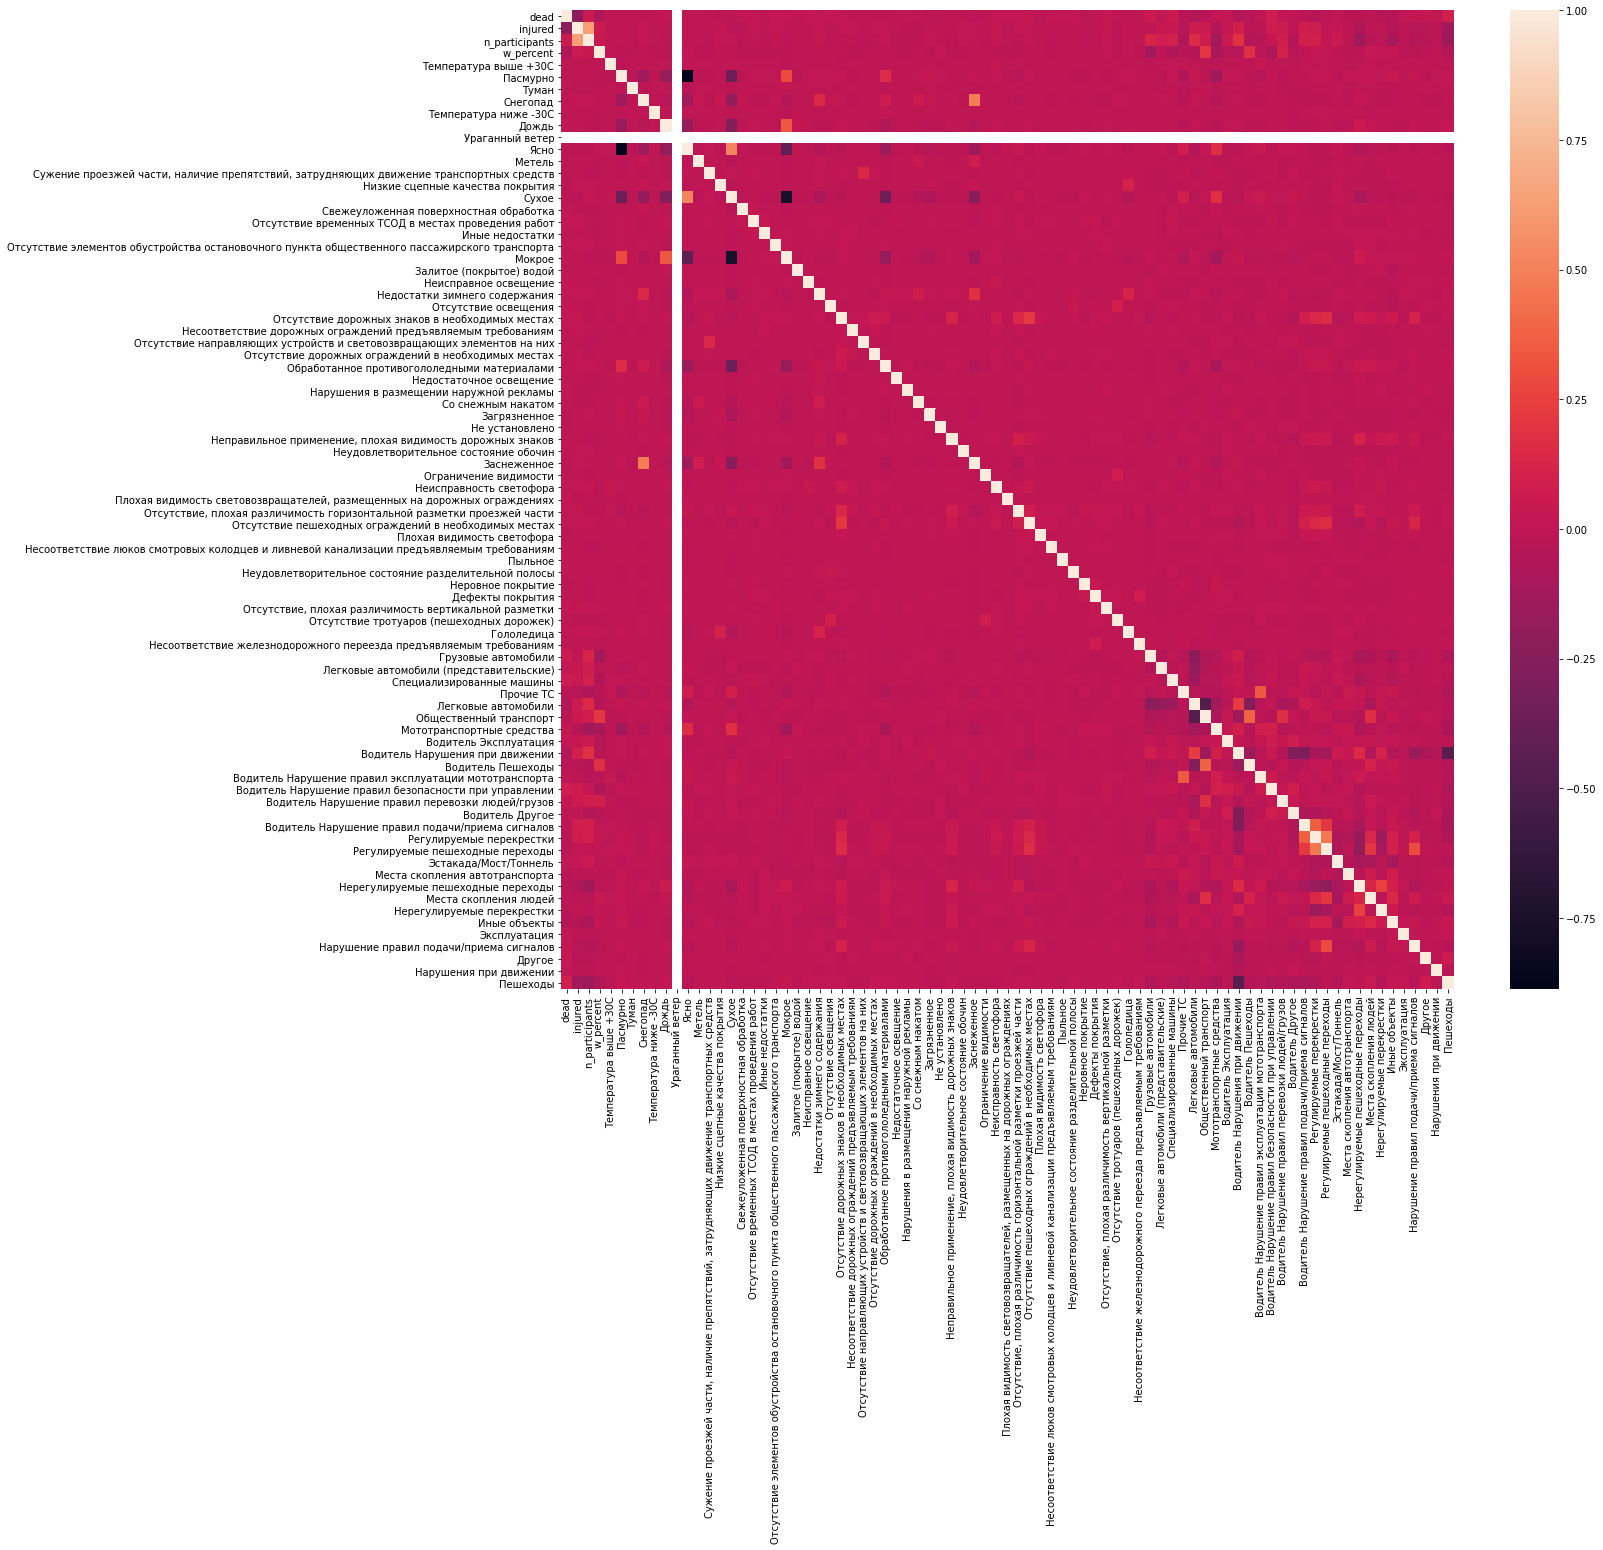

In [239]:
corr = data[cols].iloc[:, 7:].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr)
plt.show()

In [235]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
pca_transformed = pca.fit_transform(sample.values)

X = np.hstack((pca_transformed, new_embeddings.values))
y = np.where(data.dead.values==0, 0, 1)
X.shape, y.shape

((54559, 63), (54559,))

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, average_precision_score
X_tr,  X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3)

In [237]:
from sklearn.linear_model import LogisticRegression

In [238]:
lr = LogisticRegression()
lr.fit(X_tr, y_tr)
pr = lr.predict(X_ts)
proba = lr.predict_proba(X_ts)

average_precision_score(y_ts, pr)

/opt/anaconda3/envs/project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.04918796519013989